In [2]:
sc.stop()
sc = SparkContext()
sqlContext = SQLContext(sc)

In [3]:
import pyspark
from pyspark.sql import HiveContext
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark import SparkContext
from pyspark.sql.types import StructType, StructField, StringType, DoubleType,TimestampType,IntegerType
from pyspark.sql import SQLContext
from pyspark.sql import DataFrame
from pyspark.sql.types import *
from pyspark.sql.functions import *
from datetime import *
from dateutil.parser import parse
from pyspark.sql.functions import year, dayofmonth,dayofweek, month,unix_timestamp,to_timestamp
from pyspark.sql import window, Window
from pyspark.sql.window import Window
import calendar
from time import strftime
from datetime import datetime
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf,col
import pyspark.sql.functions as func
import pyspark.sql.functions as f
from pyspark.sql import functions as F

In [4]:
spark = SparkSession \
 .builder \
 .master("local") \
 .appName("NYCER") \
 .config("spark.some.config.option", "some-value") \
 .getOrCreate()

In [5]:
data = sqlContext.read.load('311_Service_Requests_from_2010_to_Present.csv',format='com.databricks.spark.csv', header='true', inferSchema='true')

In [5]:
data.printSchema()

root
 |-- Unique Key: integer (nullable = true)
 |-- Created Date: string (nullable = true)
 |-- Closed Date: string (nullable = true)
 |-- Agency: string (nullable = true)
 |-- Agency Name: string (nullable = true)
 |-- Complaint Type: string (nullable = true)
 |-- Descriptor: string (nullable = true)
 |-- Location Type: string (nullable = true)
 |-- Incident Zip: string (nullable = true)
 |-- Incident Address: string (nullable = true)
 |-- Street Name: string (nullable = true)
 |-- Cross Street 1: string (nullable = true)
 |-- Cross Street 2: string (nullable = true)
 |-- Intersection Street 1: string (nullable = true)
 |-- Intersection Street 2: string (nullable = true)
 |-- Address Type: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Landmark: string (nullable = true)
 |-- Facility Type: string (nullable = true)
 |-- Status: string (nullable = true)
 |-- Due Date: string (nullable = true)
 |-- Resolution Description: string (nullable = true)
 |-- Resolution Actio

In [6]:
data_rdd = data.rdd
'''
data_rdd.persist(pyspark.StorageLevel.MEMORY_ONLY)
data_rdd.getStorageLevel()
print(data_rdd.getStorageLevel())
'''

'\ndata_rdd.persist(pyspark.StorageLevel.MEMORY_ONLY)\ndata_rdd.getStorageLevel()\nprint(data_rdd.getStorageLevel())\n'

In [49]:
df = data_rdd.map(lambda d:(d[0],d[1],d[2],d[3],d[4],d[5],d[6],d[7],d[8],d[9],
                        d[10],d[11],d[12],d[13],d[14],d[15],d[16],d[17],d[18],d[19],
                        d[20],d[21],d[22],d[23],d[24],d[25],d[26],d[27],d[28],d[29],
                        d[30],d[31],d[32],d[33],d[34],d[35],d[36],d[37],d[38],d[39],d[40]))

In [10]:
'''
nycer_df = sqlContext.createDataFrame(df,["unique_key","created_date","closed_date","agency","agency_name","complaint_type"
                                    ,"descriptor","status","due_date","resolution_action_updated_date","resolution_description",
                                    "location_type","incident_zip","incident_address","street_name","crossstreet_1","cross_street_2"
                                    ,"intersection_street_1","intersection_street_2","address_type","city","landmark","facility_type"
                                    ,"community_board","bbl","borough","x_coordinate","y_coordinate","open_data_channel_type","latitude"
                                    ,"longitude","location","park_facility_name","park_borough","vehicle_type","taxi_company_borough"
                                    ,"taxi_pick_up_location","bridge_highway_name","bridge_highway_direction","road_ramp","bridgehighway_segment"])
'''

'\nnycer_df = sqlContext.createDataFrame(df,["unique_key","created_date","closed_date","agency","agency_name","complaint_type"\n                                    ,"descriptor","status","due_date","resolution_action_updated_date","resolution_description",\n                                    "location_type","incident_zip","incident_address","street_name","crossstreet_1","cross_street_2"\n                                    ,"intersection_street_1","intersection_street_2","address_type","city","landmark","facility_type"\n                                    ,"community_board","bbl","borough","x_coordinate","y_coordinate","open_data_channel_type","latitude"\n                                    ,"longitude","location","park_facility_name","park_borough","vehicle_type","taxi_company_borough"\n                                    ,"taxi_pick_up_location","bridge_highway_name","bridge_highway_direction","road_ramp","bridgehighway_segment"])\n'

In [7]:
schema = StructType([StructField("created_date", StringType(), True), 
                     StructField("closed_date", StringType(), True),
                     StructField("agency", StringType(), True),
                     StructField("complaint_type", StringType(), True),
                     StructField("location", StringType(), True)])
df = sqlContext.createDataFrame(data_rdd.map(lambda d:(d[1],d[2],d[3],d[5],d[25])), schema=schema)

In [9]:
def spark_shape(self):
    return (self.count(),len(self.columns))
pyspark.sql.dataframe.DataFrame.shape = spark_shape

In [8]:
df = df.na.drop(subset=["closed_date"])

In [104]:
df.shape()

(19710524, 5)

In [207]:
df.printSchema()

root
 |-- created_date: string (nullable = true)
 |-- closed_date: string (nullable = true)
 |-- agency: string (nullable = true)
 |-- complaint_type: string (nullable = true)
 |-- location: string (nullable = true)
 |-- parsed_created_date: string (nullable = true)
 |-- parsed_closed_date: string (nullable = true)
 |-- response_time: integer (nullable = true)



In [10]:
df = df.withColumn("parsed_created_date",f.from_unixtime(f.unix_timestamp("created_date",'MM/dd/yyyy hh:mm:ss aa'),
                                                    'MM/dd/yyyy HH:mm:ss'))
df = df.withColumn("parsed_closed_date",f.from_unixtime(f.unix_timestamp("closed_date",'MM/dd/yyyy hh:mm:ss aa'),
                                                    'MM/dd/yyyy HH:mm:ss'))

In [11]:
timefmt='MM/dd/yyyy HH:mm:ss'
timeDiff = (F.unix_timestamp("parsed_closed_date",format=timefmt) - 
           F.unix_timestamp("parsed_created_date",format=timefmt))/3600
df = df.withColumn("response_time",timeDiff.cast(DoubleType()))

In [125]:
df.shape()

(18849791, 8)

In [12]:
df = df.where(col('response_time')>=0)
df = df.where((col('agency') == 'NYPD') |
              (col('agency') == 'HPD') |
              (col('agency') == 'DOT') |
              (col('agency') == 'DSNY') | 
              (col('agency') == 'DEP') | 
              (col('agency') == 'DOB') | 
              (col('agency') == 'DPR') |
              (col('agency') == 'DOHMH'))
df = df.filter(~df["complaint_type"].like("%bulky%"))
df = df.where((col('location') == 'BROOKLYN') |
              (col('location') == 'QUEENS') |
              (col('location') == 'MANHATTAN') |
              (col('location') == 'BRONX') | 
              (col('location') == 'STATEN ISLAND'))
'df = df.filter(col("year") >= 2015)'

'df = df.filter(col("year") >= 2015)'

In [189]:
df.head(2)

[Row(created_date='12/05/2014 12:00:00 AM', closed_date='12/13/2014 12:00:00 AM', agency='HPD', complaint_type='HEAT/HOT WATER', location='QUEENS', parsed_created_date='12/05/2014 00:00:00', parsed_closed_date='12/13/2014 00:00:00', response_time=192, year=None),
 Row(created_date='12/05/2014 12:00:00 AM', closed_date='12/10/2014 12:00:00 AM', agency='HPD', complaint_type='HEAT/HOT WATER', location='QUEENS', parsed_created_date='12/05/2014 00:00:00', parsed_closed_date='12/10/2014 00:00:00', response_time=120, year=None)]

In [13]:
df_agency = df.where(df.agency =="NYPD")
df_agency_rdd = df_agency.select(df.parsed_created_date,df.parsed_closed_date,df.agency,df.response_time).rdd

In [14]:
df_agency = df_agency_rdd.map(lambda d:(parse(d[0]),parse(d[1]),d[2],d[3])).toDF()

In [214]:
df_agency.head(2)

[Row(_1=datetime.datetime(2014, 8, 20, 20, 3, 57), _2=datetime.datetime(2014, 8, 20, 22, 32, 1), _3='NYPD', _4=2),
 Row(_1=datetime.datetime(2014, 8, 21, 0, 29, 37), _2=datetime.datetime(2014, 8, 21, 4, 32, 28), _3='NYPD', _4=4)]

In [15]:
newcolnames = ['created_date','closed_date','agency','response_time']
for c,n in zip(df_agency.columns,newcolnames):
    df_agency=df_agency.withColumnRenamed(c,n)

In [16]:
df_agency = df_agency.filter(year(df_agency.created_date) >= 2015)
df_agency = df_agency.filter(year(df_agency.created_date) <= 2018).orderBy("created_date")

In [28]:
df_agency

[Row(created_date=datetime.datetime(2015, 1, 1, 0, 0, 50), closed_date=datetime.datetime(2015, 1, 1, 2, 47, 50), agency='NYPD', response_time=2.783333333333333, created_dt=datetime.date(2015, 1, 1), DayofWeek=5),
 Row(created_date=datetime.datetime(2015, 1, 1, 0, 1, 29), closed_date=datetime.datetime(2015, 1, 1, 2, 42, 22), agency='NYPD', response_time=2.681388888888889, created_dt=datetime.date(2015, 1, 1), DayofWeek=5),
 Row(created_date=datetime.datetime(2015, 1, 1, 0, 1, 30), closed_date=datetime.datetime(2015, 1, 1, 0, 20, 33), agency='NYPD', response_time=0.3175, created_dt=datetime.date(2015, 1, 1), DayofWeek=5),
 Row(created_date=datetime.datetime(2015, 1, 1, 0, 4, 28), closed_date=datetime.datetime(2015, 1, 1, 2, 25, 2), agency='NYPD', response_time=2.3427777777777776, created_dt=datetime.date(2015, 1, 1), DayofWeek=5),
 Row(created_date=datetime.datetime(2015, 1, 1, 0, 4, 44), closed_date=datetime.datetime(2015, 1, 1, 10, 22, 31), agency='NYPD', response_time=10.2963888888888

In [242]:
df_agency.printSchema()

root
 |-- created_date: timestamp (nullable = true)
 |-- closed_date: timestamp (nullable = true)
 |-- agency: string (nullable = true)
 |-- response_time: long (nullable = true)



In [17]:
df_agency = df_agency.withColumn('created_dt',df_agency['created_date'].
                                  cast('date'))

In [250]:
df_agency.head(3)

[Row(created_date=datetime.datetime(2015, 1, 1, 0, 0, 50), closed_date=datetime.datetime(2015, 1, 1, 2, 47, 50), agency='NYPD', response_time=2, created_dt=datetime.date(2015, 1, 1)),
 Row(created_date=datetime.datetime(2015, 1, 1, 0, 1, 29), closed_date=datetime.datetime(2015, 1, 1, 2, 42, 22), agency='NYPD', response_time=2, created_dt=datetime.date(2015, 1, 1)),
 Row(created_date=datetime.datetime(2015, 1, 1, 0, 1, 30), closed_date=datetime.datetime(2015, 1, 1, 0, 20, 33), agency='NYPD', response_time=0, created_dt=datetime.date(2015, 1, 1))]

In [18]:
#1 = Sunday, 2 = Monday, ..., 7 = Saturday).
df_agency = df_agency.withColumn('DayofWeek', dayofweek(df_agency.created_dt))

In [19]:
start_date = df_agency.select(df_agency.created_dt).where(df_agency.DayofWeek == 1).orderBy(df_agency.created_dt).distinct()



In [21]:
start_date = start_date.rdd

In [22]:
start_date = start_date.toDF().toPandas()

In [23]:
start_date

,created_dt
0,2015-01-04
1,2015-01-11
2,2015-01-18
3,2015-01-25
4,2015-02-01
5,2015-02-08
6,2015-02-15
7,2015-02-22
8,2015-03-01
9,2015-03-08


In [254]:
date = start_date.head(1)
date

,created_dt
0,2015-01-04
1,2015-01-11


In [1]:
def median(values_list):
    med = np.median(values_list)
    return float(med)
udf_median = func.udf(median, FloatType())


df_grouped = df_agency.groupby("created_dt").agg(udf_median(func.collect_list(col('response_time'))).alias('response_time')).orderBy("created_dt")

NameError: name 'func' is not defined

In [32]:
grouped_median = df_grouped.toPandas()

Py4JJavaError: An error occurred while calling o369.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 17.0 failed 1 times, most recent failure: Lost task 1.0 in stage 17.0 (TID 1395, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 253, in main
    process()
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 248, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/opt/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 331, in dump_stream
    self.serializer.dump_stream(self._batched(iterator), stream)
  File "/opt/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 140, in dump_stream
    for obj in iterator:
  File "/opt/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 320, in _batched
    for item in iterator:
  File "<string>", line 1, in <lambda>
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 76, in <lambda>
    return lambda *a: f(*a)
  File "/opt/spark/python/lib/pyspark.zip/pyspark/util.py", line 55, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-31-462b68cdf27b>", line 2, in median
NameError: name 'np' is not defined

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:330)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:83)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:66)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:284)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:439)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage3.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$10$$anon$1.hasNext(WholeStageCodegenExec.scala:614)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at org.apache.spark.util.random.SamplingUtils$.reservoirSampleAndCount(SamplingUtils.scala:41)
	at org.apache.spark.RangePartitioner$$anonfun$13.apply(Partitioner.scala:306)
	at org.apache.spark.RangePartitioner$$anonfun$13.apply(Partitioner.scala:304)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsWithIndex$1$$anonfun$apply$26.apply(RDD.scala:853)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsWithIndex$1$$anonfun$apply$26.apply(RDD.scala:853)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:49)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1651)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1639)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1638)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1638)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1872)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1821)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1810)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:642)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2034)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2055)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2074)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2099)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:945)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:944)
	at org.apache.spark.RangePartitioner$.sketch(Partitioner.scala:309)
	at org.apache.spark.RangePartitioner.<init>(Partitioner.scala:171)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec$.prepareShuffleDependency(ShuffleExchangeExec.scala:224)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec.prepareShuffleDependency(ShuffleExchangeExec.scala:91)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec$$anonfun$doExecute$1.apply(ShuffleExchangeExec.scala:128)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec$$anonfun$doExecute$1.apply(ShuffleExchangeExec.scala:119)
	at org.apache.spark.sql.catalyst.errors.package$.attachTree(package.scala:52)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec.doExecute(ShuffleExchangeExec.scala:119)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:131)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.InputAdapter.inputRDDs(WholeStageCodegenExec.scala:371)
	at org.apache.spark.sql.execution.SortExec.inputRDDs(SortExec.scala:121)
	at org.apache.spark.sql.execution.WholeStageCodegenExec.doExecute(WholeStageCodegenExec.scala:605)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:131)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan.getByteArrayRdd(SparkPlan.scala:247)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:294)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:3200)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:3197)
	at org.apache.spark.sql.Dataset$$anonfun$52.apply(Dataset.scala:3259)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:77)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3258)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:3197)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 253, in main
    process()
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 248, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/opt/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 331, in dump_stream
    self.serializer.dump_stream(self._batched(iterator), stream)
  File "/opt/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 140, in dump_stream
    for obj in iterator:
  File "/opt/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 320, in _batched
    for item in iterator:
  File "<string>", line 1, in <lambda>
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 76, in <lambda>
    return lambda *a: f(*a)
  File "/opt/spark/python/lib/pyspark.zip/pyspark/util.py", line 55, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-31-462b68cdf27b>", line 2, in median
NameError: name 'np' is not defined

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:330)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:83)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:66)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:284)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:439)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage3.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$10$$anon$1.hasNext(WholeStageCodegenExec.scala:614)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at org.apache.spark.util.random.SamplingUtils$.reservoirSampleAndCount(SamplingUtils.scala:41)
	at org.apache.spark.RangePartitioner$$anonfun$13.apply(Partitioner.scala:306)
	at org.apache.spark.RangePartitioner$$anonfun$13.apply(Partitioner.scala:304)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsWithIndex$1$$anonfun$apply$26.apply(RDD.scala:853)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsWithIndex$1$$anonfun$apply$26.apply(RDD.scala:853)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:49)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [70]:
date = date['created_dt']

In [71]:
df_agency_filtered = df_agency.where((df_agency.created_dt >= date) & (df_agency.created_dt <= date + timedelta(days=21))).orderBy("created_dt")

In [73]:
df_agency_filtered.select(df_agency_filtered.created_dt).distinct().show()

+----------+
|created_dt|
+----------+
|2015-01-04|
|2015-01-05|
|2015-01-06|
|2015-01-07|
|2015-01-08|
|2015-01-09|
|2015-01-10|
|2015-01-11|
|2015-01-12|
|2015-01-13|
|2015-01-14|
|2015-01-15|
|2015-01-16|
|2015-01-17|
|2015-01-18|
|2015-01-19|
|2015-01-20|
|2015-01-21|
|2015-01-22|
|2015-01-23|
+----------+
only showing top 20 rows



In [97]:
train = df_agency_filtered.where((df_agency_filtered.created_dt >= date) \
                                 & (df_agency_filtered.created_dt <= date + timedelta(days=13))) \
                                .orderBy("created_date")

In [109]:
test = df_agency_filtered.select("created_date","closed_date","agency","created_dt","DayofWeek","response_time"). \
                where(df_agency_filtered.created_dt > date + timedelta(days=13)).orderBy("created_date")

In [99]:
train = train.toPandas()

In [100]:
train.head()

,created_date,closed_date,agency,response_time,created_dt,DayofWeek
0,2015-01-04 00:00:02,2015-01-04 08:22:30,NYPD,8.374444,2015-01-04,1
1,2015-01-04 00:00:04,2015-01-04 02:37:01,NYPD,2.615833,2015-01-04,1
2,2015-01-04 00:00:41,2015-01-04 03:23:30,NYPD,3.380278,2015-01-04,1
3,2015-01-04 00:01:01,2015-01-04 00:45:39,NYPD,0.743889,2015-01-04,1
4,2015-01-04 00:01:29,2015-01-04 01:00:30,NYPD,0.983611,2015-01-04,1


In [110]:
test = test.toPandas()

In [111]:
test.head()

,created_date,closed_date,agency,created_dt,DayofWeek,response_time
0,2015-01-18 00:00:18,2015-01-18 10:25:02,NYPD,2015-01-18,1,10.412222
1,2015-01-18 00:00:34,2015-01-18 00:29:16,NYPD,2015-01-18,1,0.478333
2,2015-01-18 00:01:04,2015-01-18 05:37:28,NYPD,2015-01-18,1,5.606667
3,2015-01-18 00:01:06,2015-01-18 07:56:51,NYPD,2015-01-18,1,7.929167
4,2015-01-18 00:02:00,2015-01-18 02:56:13,NYPD,2015-01-18,1,2.903611


In [276]:
train.to_pickle('train.pkl')
#to load the file back, use train = pd.read_pickle('train.pkl')
test.to_pickle('test.pkl')
#to load the file back, use test = pd.read_pickle('test.pkl')
start_date.to_pickle('start_date.pkl')


grouped_median.to_pickle('grouped_median.pkl')

In [128]:
start_date = pd.read_pickle('start_date.pkl')
df_grouped = pd.read_pickle('grouped_median.pkl')

In [123]:
grouped_train = train.groupby(train.created_dt).median()
grouped_test = test.groupby(test.created_dt).median()

In [206]:
grouped_train['response_time']

created_dt
2015-01-04    2.434583
2015-01-05    2.867500
2015-01-06    2.551389
2015-01-07    2.573611
2015-01-08    2.528889
2015-01-09    2.703889
2015-01-10    2.285556
2015-01-11    2.309861
2015-01-12    2.782083
2015-01-13    2.415556
2015-01-14    2.734444
2015-01-15    2.726944
2015-01-16    2.645694
2015-01-17    2.250000
Name: response_time, dtype: float64

In [225]:
grouped_test['response_time']

created_dt
2015-01-18    2.197778
2015-01-19    2.340556
2015-01-20    2.506944
2015-01-21    2.447778
2015-01-22    2.466111
2015-01-23    2.804306
2015-01-24    2.449444
2015-01-25    2.253333
Name: response_time, dtype: float64

In [230]:
test_X = grouped_test.index
test_Y = grouped_test['response_time']



test_Y = test_Y.values.reshape(-1, 1)
test_X = test_X.values.reshape(-1, 1)
test_X = test_X.astype('datetime64[D]').astype(float)

train_X = grouped_train.index
train_Y = grouped_train['response_time']

train_X = train_X.values.reshape(-1, 1)
train_Y = train_Y.values.reshape(-1, 1)
train_X = train_X.astype('datetime64[D]').astype(float)

In [216]:
train_Y

array([[2.43458333],
       [2.8675    ],
       [2.55138889],
       [2.57361111],
       [2.52888889],
       [2.70388889],
       [2.28555556],
       [2.30986111],
       [2.78208333],
       [2.41555556],
       [2.73444444],
       [2.72694444],
       [2.64569444],
       [2.25      ]])

In [73]:
import math 
import numpy as np
from sklearn import datasets,linear_model
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pylab as plt
from sklearn import preprocessing
from math import sqrt
from statistics import mean 
import math
from matplotlib import pyplot

In [8]:
%matplotlib inline
from matplotlib.pylab import rcParams,pyplot
rcParams['figure.figsize'] = 15, 6

ImportError: cannot import name 'pyplot' from 'matplotlib.pylab' (/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/pylab.py)

In [227]:
lasso = Lasso(alpha=0.1, copy_X=True,fit_intercept=True, max_iter=1)
lasso.fit(train_X,train_Y)
pred = lasso.predict(test_X)
sqrt(mean_squared_error(test_Y, pred))

0.21366706481182757

In [189]:
test_Y

array([[0.14912281],
       [0.00633639],
       [0.08004935],
       ...,
       [0.03119485],
       [0.01183033],
       [0.07224365]])

In [217]:
pred

array([[2.51761447],
       [2.51224878],
       [2.50688309],
       [2.5015174 ],
       [2.49615171],
       [2.49078602],
       [2.48542033],
       [2.48005464]])

In [234]:
lr = LinearRegression()
lr.fit(train_X,train_Y)
pred = lr.predict(test_X)
sqrt(mean_squared_error(test_Y, pred))

0.18926032823908623

In [8]:
from dask import dataframe as ddf

In [102]:
dd = ddf.from_pandas(df_grouped, npartitions=8)
df_grouped

,created_dt,response_time
0,2015-01-01,2.207500
1,2015-01-02,2.552917
2,2015-01-03,2.665694
3,2015-01-04,2.434583
4,2015-01-05,2.867500
5,2015-01-06,2.551389
6,2015-01-07,2.573611
7,2015-01-08,2.528889
8,2015-01-09,2.703889
9,2015-01-10,2.285556


In [44]:
start_date = pd.read_pickle('start_date.pkl')
df_grouped = pd.read_pickle('grouped_median.pkl')
decimals = 2
df_grouped['response_time'] = df_grouped['response_time'].round(2)

In [45]:
start_date.drop(start_date.tail(3).index,inplace=True)

In [110]:
RMSE = []
for index,row in start_date.iterrows():
    date = row['created_dt']
    df_agency_filtered = df_grouped.loc[(df_grouped['created_dt'] >= date) & \
                                         (df_grouped['created_dt'] < date + timedelta(days=21))].sort_values('created_dt')
    train = df_agency_filtered.loc[(df_agency_filtered['created_dt'] >= date) \
                                 & (df_agency_filtered['created_dt'] <= date + timedelta(days=13))] \
                                .sort_values('created_dt')
    test = df_agency_filtered.loc[(df_agency_filtered['created_dt'] > date + timedelta(days=13)) \
                                  & (df_agency_filtered['created_dt'] < date + timedelta(days=21)) ].sort_values('created_dt')
    test_X = test.index
    test_Y = test['response_time']



    test_Y = test_Y.values.reshape(-1, 1)
    test_X = test_X.values.reshape(-1, 1)
    test_X = test_X.astype('datetime64[D]').astype(float)

    train_X = train.index
    train_Y = train['response_time']

    train_X = train_X.values.reshape(-1, 1)
    train_Y = train_Y.values.reshape(-1, 1)
    train_X = train_X.astype('datetime64[D]').astype(float)
    
    #lr = LinearRegression()
    #lr.fit(train_X,train_Y)
    #pred = lr.predict(test_X)
    #pred = pred.round(2)
    lasso = Lasso(alpha=0.1, copy_X=True,fit_intercept=True, max_iter=1)
    lasso.fit(train_X,train_Y)
    pred = lasso.predict(test_X)
    pred = pred.round(2)
    err = sqrt(mean_squared_error(test_Y, pred))
    RMSE.append(err)
print("RMSE:",np.round(mean(RMSE),2))

RMSE: 0.3


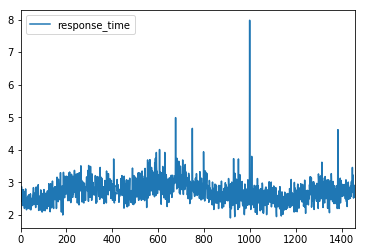

In [10]:
df_grouped.plot()
pyplot.show()

In [71]:
series

created_dt
2015-01-04    2.43
2015-01-05    2.87
2015-01-06    2.55
2015-01-07    2.57
2015-01-08    2.53
2015-01-09    2.70
2015-01-10    2.29
2015-01-11    2.31
2015-01-12    2.78
2015-01-13    2.42
2015-01-14    2.73
2015-01-15    2.73
2015-01-16    2.65
2015-01-17    2.25
2015-01-18    2.20
2015-01-19    2.34
2015-01-20    2.51
2015-01-21    2.45
2015-01-22    2.47
2015-01-23    2.80
2015-01-24    2.45
Name: response_time, dtype: float32

In [104]:
RMSE = []
import warnings
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(arima_order):
    # prepare training dataset
    for index,row in start_date.iterrows():
        date = row['created_dt']
        df_agency_filtered = df_grouped.loc[(df_grouped['created_dt'] >= date) & \
                                             (df_grouped['created_dt'] < date + timedelta(days=21))].sort_values('created_dt')
        train = df_agency_filtered.loc[(df_agency_filtered['created_dt'] >= date) \
                                     & (df_agency_filtered['created_dt'] <= date + timedelta(days=13))] \
                                    .sort_values('created_dt')
        test = df_agency_filtered.loc[(df_agency_filtered['created_dt'] > date + timedelta(days=13)) \
                                      & (df_agency_filtered['created_dt'] < date + timedelta(days=21)) ].sort_values('created_dt')
        train = train.set_index('created_dt')
        train = train.T.squeeze()

        test = test.set_index('created_dt')
        test = test.T.squeeze()
        history = [x for x in train]
        # make predictions
        predictions = list()
        for t in range(len(test)):
            model = ARIMA(history, order=arima_order)
            model_fit = model.fit(disp=0)
            yhat = model_fit.forecast()[0]
            predictions.append(yhat)
            history.append(test[t])
        # calculate out of sample error
        error = mean_squared_error(test, predictions)
        return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

# load dataset




# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(p_values, d_values, q_values)



ARIMA(0, 0, 0) MSE=0.037
ARIMA(0, 0, 1) MSE=0.049
ARIMA(0, 0, 2) MSE=0.058
ARIMA(0, 1, 0) MSE=0.044
ARIMA(0, 1, 1) MSE=0.044
ARIMA(0, 1, 2) MSE=0.052
ARIMA(0, 2, 0) MSE=0.122
ARIMA(0, 2, 1) MSE=0.059
ARIMA(1, 0, 0) MSE=0.049
ARIMA(1, 1, 0) MSE=0.047
ARIMA(1, 2, 0) MSE=0.103
ARIMA(2, 0, 0) MSE=0.055
ARIMA(2, 1, 0) MSE=0.055
ARIMA(2, 2, 0) MSE=0.089
ARIMA(4, 0, 0) MSE=0.059
ARIMA(4, 1, 0) MSE=0.080
ARIMA(4, 2, 0) MSE=0.115
Best ARIMA(0, 0, 0) MSE=0.037


In [107]:
for index,row in start_date.iterrows():
        date = row['created_dt']
        df_agency_filtered = df_grouped.loc[(df_grouped['created_dt'] >= date) & \
                                             (df_grouped['created_dt'] < date + timedelta(days=21))].sort_values('created_dt')
        train = df_agency_filtered.loc[(df_agency_filtered['created_dt'] >= date) \
                                     & (df_agency_filtered['created_dt'] <= date + timedelta(days=13))] \
                                    .sort_values('created_dt')
        test = df_agency_filtered.loc[(df_agency_filtered['created_dt'] > date + timedelta(days=13)) \
                                      & (df_agency_filtered['created_dt'] < date + timedelta(days=21)) ].sort_values('created_dt')
        train = train.set_index('created_dt')
        train = train.T.squeeze()

        test = test.set_index('created_dt')
        test = test.T.squeeze()
        history = [x for x in train]
        # make predictions
        predictions = list()
        for t in range(len(test)):
            model = ARIMA(history, order=(0,0,0))
            model_fit = model.fit(disp=0)
            yhat = model_fit.forecast()[0]
            predictions.append(yhat)
            history.append(test[t])
        # calculate out of sample error
        error = sqrt(mean_squared_error(test, predictions))
        RMSE.append(error)

print("RMSE:",np.round(mean(RMSE),2))

RMSE: 0.28
